# Breast Cancer and Survival Rate 

# Setup

In [1]:
import os 
import numpy as np
import pandas as pd

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, precision_score, recall_score,  accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel

# from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline

SEED = np.random.seed(0)

Import Data

In [2]:
path = os.getcwd() + os.path.abspath('/datasets/Breast_Cancer.csv')
df = pd.read_csv(path)
df.dropna(how='all')

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


# Data Cleaning and Analysis

### Description of Features
**Numerical Columns**


`Age`: how old the patients are from 30-69

`Tumor Size`: size of tumor in millimeters

`Regional Node Examined`: amount of regional nodes looked at

`Reginol Node Positive`: amount nodes with cancer

`Survival Months`: months survived with breast cancer


**Categorical Columns**

`Race`: white, black, other

`Marital Status`: single, married, divorced, separated, widowed

`T Stage`:

- T1 = 2cm
- T2 = 2-4 cm
- T3 = 4-6 cm
- T4 = >6 cm

`N Stage`:

- N1 = cancer extended to 1-3 axillary lymph nodes
- N2 = cancer extended to 4-9 axillary lymph nodes
- N3 = cancer extended to >= 10 axillary lymph nodes

`6th Stage`:

- IIA = cancer has either extended to 1-3 axillary lymph nodes or a 2 - 5 cm tumor is discovered in the breast
- IIB = tumor is both 2 - 5 cm and has also extended into 1-3 axillary lymph nodes or tumor is over 5cm but has not spread
- IIIA = tumor is discovered of any centimeters in the breast or one is found only in the lymph nodes, cancer needs to be extended into =>4 lymph nodes (either in the breast or axilla)
- IIIB = any size tumor extended to chest wall, is in <= 9 lymph nodes
- IIIC = any size tumor extended to chest wall, is in >= 10 lymph nodes [^AmericanCollegeOfSurgeons]
differentiate: moderately differentiated, poorly differentiated, well differentiated (whether cells look like the average breast cells we tend to see that grow slower) [^AmericanCancerSociety]

`Grade`:

- 1(cancer isn’t spreading at fast rate)
- 2 (starting to grow faster)
- 3 (cancer is increasing faster)
- anaplastic; Grade IV (cancer growing extremely quick) [^AmericanCancerSociety]
A Stage: regional (breast cancer extended to closeby body parts), distant (cancer has spread further out into the body)

`Estrogen Status`: Estrogen Status- Positive (cells have estrogen), Negative (cells don’t contain estrogen)

`Progesterone Status`: Positive (cells contain progesterone) , Negative (cells don’t contain progesterone)

`Status`: Whether patient is alive or dead

[^AmericanCollegeOfSurgeons]: American College of Surgeons. Breast Cancer Staging. https://www.facs.org/for-patients/home-skills-for-patients/breast-cancer-surgery/breast-cancer-types/breast-cancer-staging/

[^AmericanCancerSociety]: American Cancer Society. (last revised 8 November 2021). Breast Cancer Grade. https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/breast-cancer-grades.html

#### Given the above features spanning general metrics such as age, sex and race as well as clinical metrics such as tumor size, hormone metrics, etc, can we infer the cancer survival rate of a given patient?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

Numerical Columns

In [4]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_desc  = df[num_cols].describe()

old_metrics = []
for i in num_cols:

    rng = num_desc[i].loc['max'] -  num_desc[i].loc['min']
    mean = num_desc[i].loc['mean']
    std = num_desc[i].loc['std']

    old_metrics.append((mean, std, rng))
    print(f"{i}\n  Mean: {mean}\n  Std: {std}\n  Range: {rng}\n")

Age
  Mean: 53.97216699801193
  Std: 8.963134409895773
  Range: 39.0

Tumor Size
  Mean: 30.47365805168986
  Std: 21.119696090412837
  Range: 139.0

Regional Node Examined
  Mean: 14.35710735586481
  Std: 8.099674806654745
  Range: 60.0

Reginol Node Positive
  Mean: 4.158051689860835
  Std: 5.109331121622229
  Range: 45.0

Survival Months
  Mean: 71.29796222664015
  Std: 22.92142954120322
  Range: 106.0



Categorical Columns

In [5]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for i in cat_cols:
    counts = df[i].value_counts(normalize=True)
    print(f"\n{i}:\n{counts * 100}")


Race:
White    84.816103
Other     7.952286
Black     7.231610
Name: Race, dtype: float64

Marital Status:
Married      65.680915
Single       15.283300
Divorced     12.077535
Widowed       5.839960
Separated     1.118290
Name: Marital Status, dtype: float64

T Stage :
T2    44.383698
T1    39.835984
T3    13.245527
T4     2.534791
Name: T Stage , dtype: float64

N Stage:
N1    67.892644
N2    20.377734
N3    11.729622
Name: N Stage, dtype: float64

6th Stage:
IIA     32.430417
IIB     28.081511
IIIA    26.093439
IIIC    11.729622
IIIB     1.665010
Name: 6th Stage, dtype: float64

differentiate:
Moderately differentiated    58.424453
Poorly differentiated        27.609344
Well differentiated          13.494036
Undifferentiated              0.472167
Name: differentiate, dtype: float64

Grade:
2                        58.424453
3                        27.609344
1                        13.494036
 anaplastic; Grade IV     0.472167
Name: Grade, dtype: float64

A Stage:
Regional    97.713

### Check Distribution of Outliers amongst the numerical columns 

Plot Boxplot of Outliers

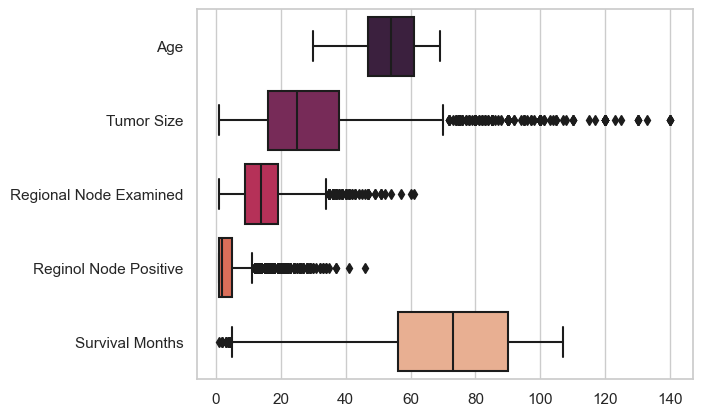

In [6]:
sns.set(style="whitegrid")
sns.boxplot(data=df[num_cols], orient="h", palette="rocket")
plt.show()

In [7]:
num_info = df[num_cols].describe()

# Calculate the interquartile range (IQR) for each column
Q1 = num_info.loc['25%']
Q3 = num_info.loc['75%']
IQR = Q3 - Q1

outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR)))

outliers.sum()

Age                         0
Tumor Size                222
Regional Node Examined     72
Reginol Node Positive     344
Survival Months            18
dtype: int64

From the above outlier calculations, we can see that `Tumor Size (222)`, `Regional Node Examined (72)`, `Reginol Node Positive (344)` and `Survival Months (18)` contain outliers. To determine if we should remove the outliers or not, let us look at the impact on the numerical variables.

In [8]:
outlier_df = df[~outliers.any(axis=1)]
outlier_df

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


Check impact of outlier removal on the numerical features


In [9]:
num_desc  = outlier_df[num_cols].describe()

for c,i in enumerate(num_cols):

    rng = num_desc[i].loc['max'] -  num_desc[i].loc['min']
    mean = num_desc[i].loc['mean']
    std = num_desc[i].loc['std']

    # Diff: old - new
    print(f"{i}\n  New Mean: {mean}, Diff: {-mean + old_metrics[c][0]}\n  New Std: {std}, Diff: {-std + old_metrics[c][1]}\n  New Range: {rng}, Diff: {-rng + old_metrics[c][2]}\n")

Age
  New Mean: 54.00493612078978, Diff: -0.03276912277785016
  New Std: 8.913905764049739, Diff: 0.049228645846033814
  New Range: 39.0, Diff: 0.0

Tumor Size
  New Mean: 26.248257839721255, Diff: 4.225400211968605
  New Std: 14.703189301827633, Diff: 6.416506788585204
  New Range: 69.0, Diff: 70.0

Regional Node Examined
  New Mean: 13.185830429732869, Diff: 1.1712769261319416
  New Std: 7.079710233239149, Diff: 1.0199645734155958
  New Range: 33.0, Diff: 27.0

Reginol Node Positive
  New Mean: 2.775842044134727, Diff: 1.3822096457261077
  New Std: 2.395958819219537, Diff: 2.713372302402692
  New Range: 10.0, Diff: 35.0

Survival Months
  New Mean: 72.57346109175377, Diff: -1.2754988651136188
  New Std: 21.781373587535718, Diff: 1.1400559536675026
  New Range: 102.0, Diff: 4.0



The outlier removal seems to heavily impact `Tumor Size`, `Regional Node Examined`, and `Regional Node Positive`. We will not remove outliers as it might skew the final predictions. This will also impact the types of models we fit the data on. Since we are not removing the outliers, we cannot use distance based models (such as SVM, Regresions, etc)

Distribution of Numerical features


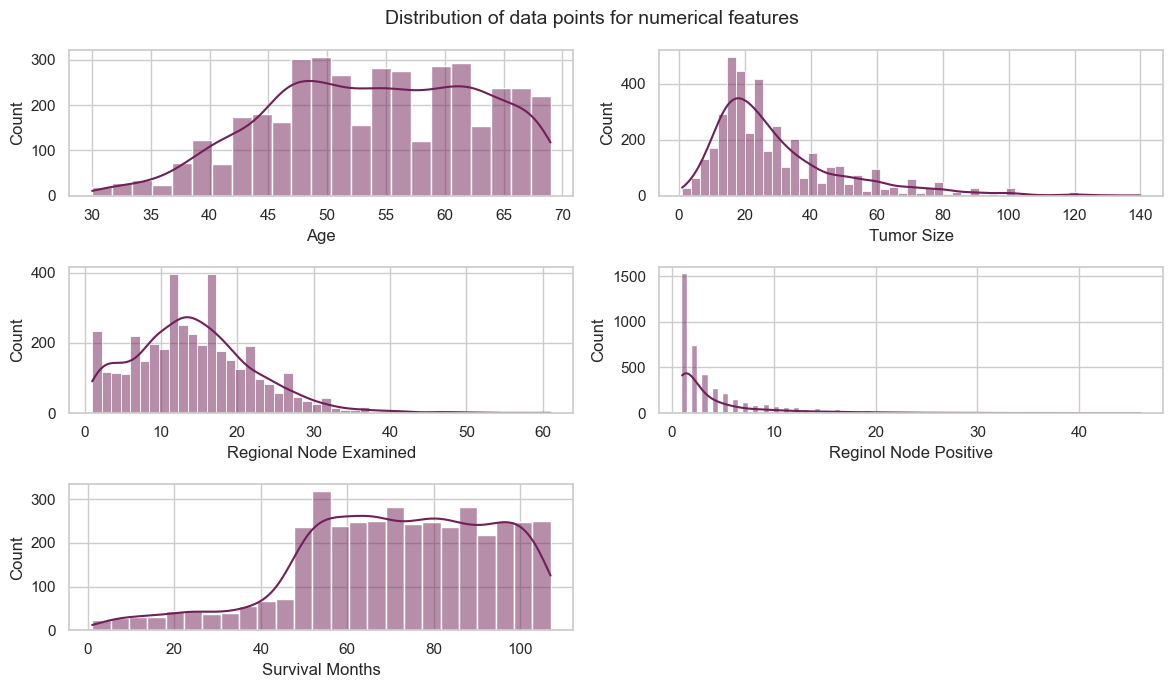

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,7), dpi=100)
fig.suptitle('Distribution of data points for numerical features', fontsize=14)


for col, ax in zip(num_cols, axes.ravel()):
    sns.histplot(data=df, x=col, kde='True', color=sns.color_palette('rocket').as_hex()[1], ax=ax)
    ax.set_xlabel(col)

fig.tight_layout()
fig.delaxes(axes[2,1])

Based on the above plots, `Tumor Size`,`Regional Node Examined`, and `Reginol Node Positive` are heavily right skewed; `Age`, and `Surivival Months` are moderately skewed

Correlation amongst numerical columns

/var/folders/75/r37xf4bj0nd53bwdj7pzr7br0000gn/T/ipykernel_27984/3174603021.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='rocket')


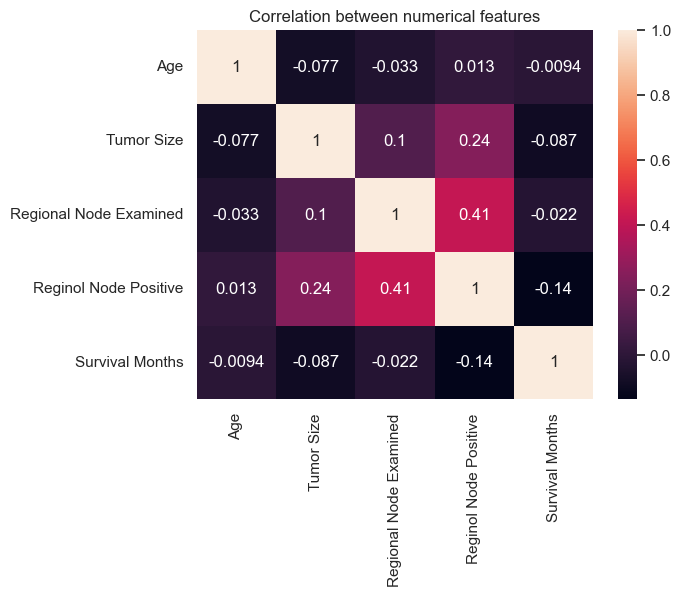

In [11]:
sns.heatmap(df.corr(), annot=True, cmap='rocket')
plt.title('Correlation between numerical features');

Based on the above heatmap, there are no strong correlations between each of the numeric variables


### Imbalances of the target class


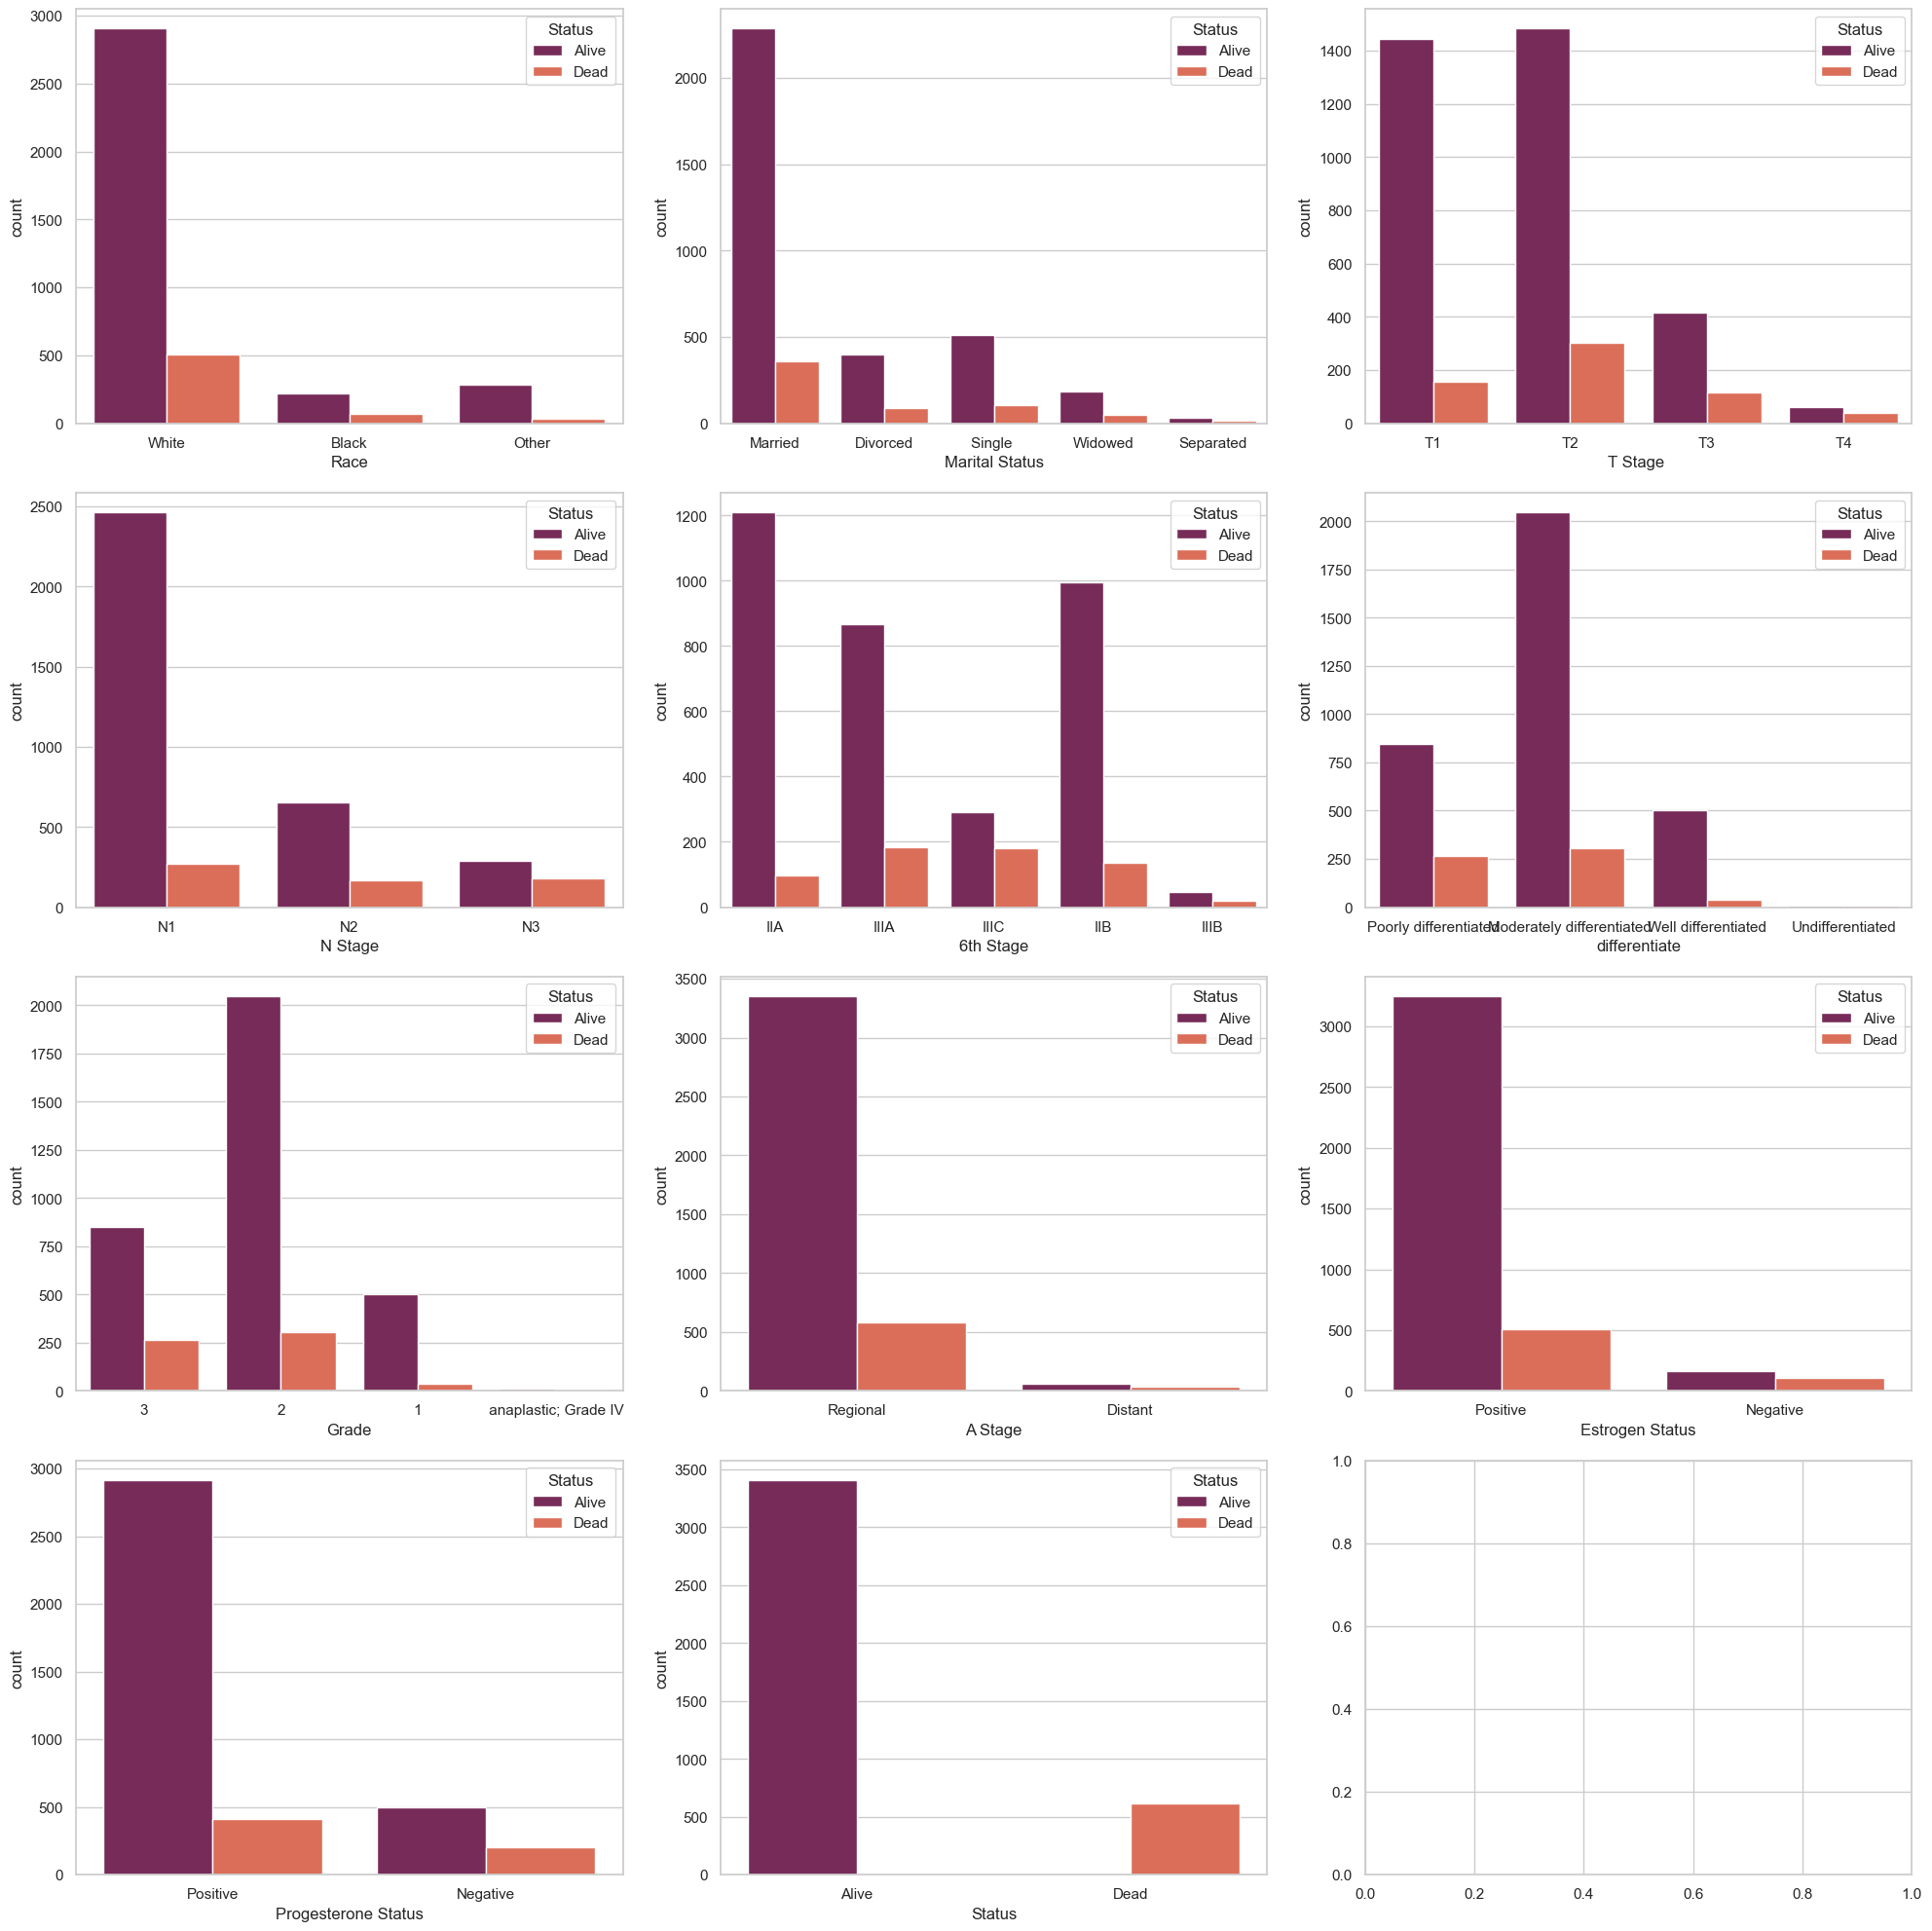

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20), dpi=100)
for col, ax in zip(cat_cols, axes.ravel()):
    sns.countplot(data=df, x=col, hue='Status', palette='rocket', ax=ax)
    
plt.tight_layout()

From the above barplots, we can see that there is a significant imbalance in the target class (`Status`) amongst the categorical features.

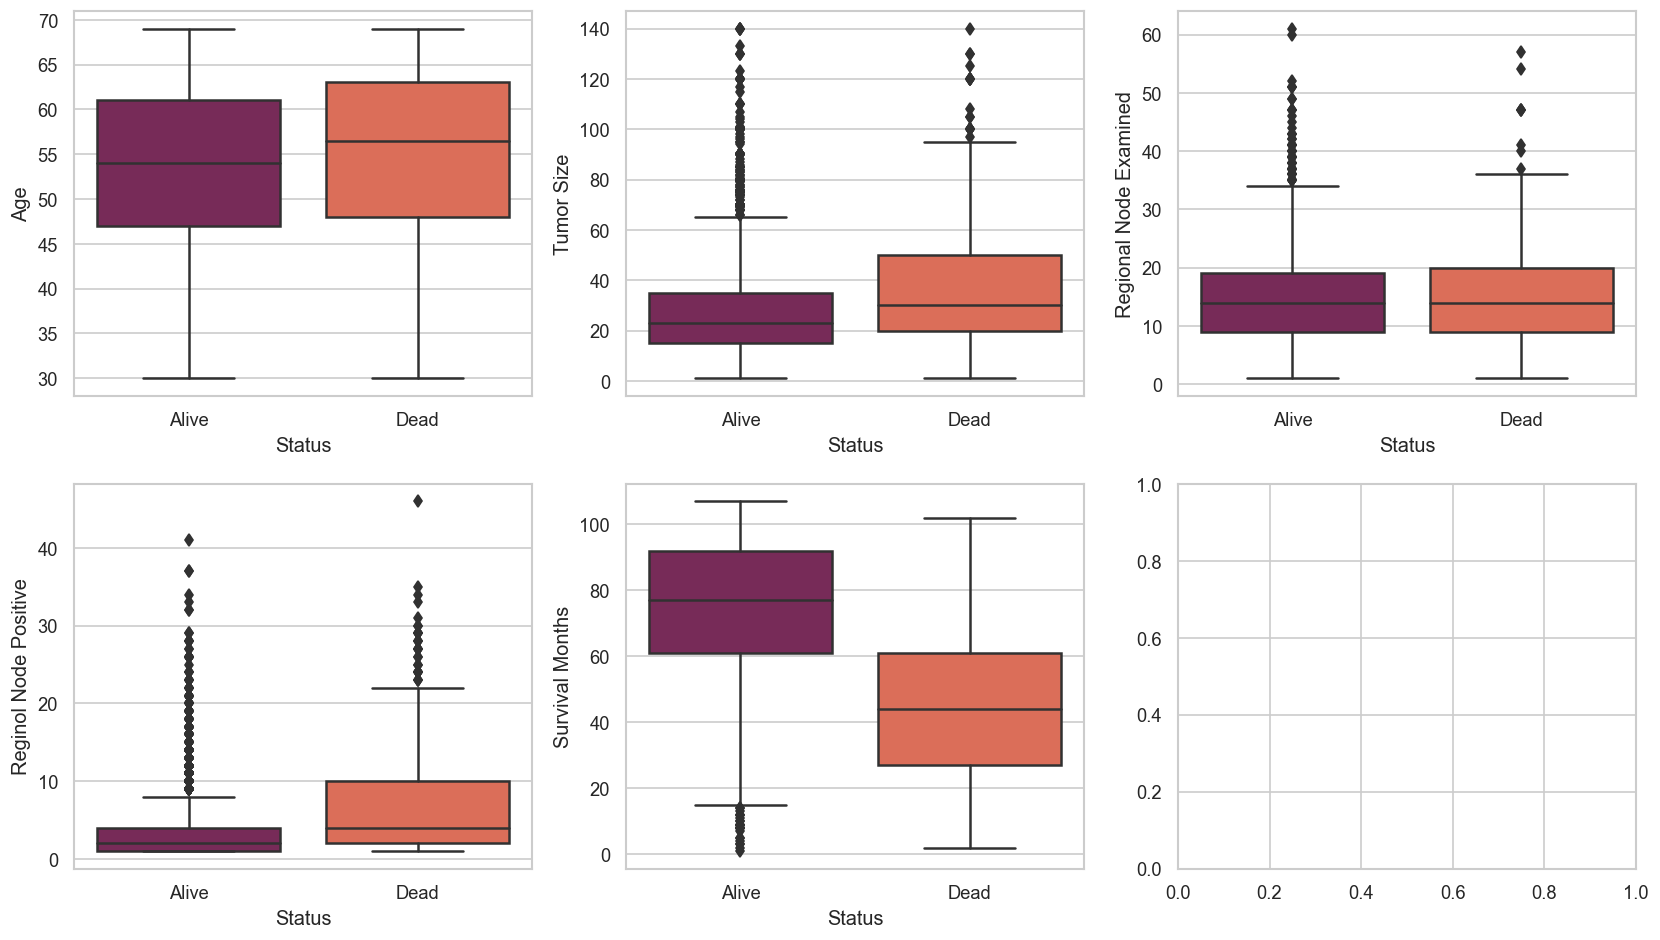

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8), dpi=120)
for col, ax in zip(num_cols, axes.ravel()):
    sns.boxplot(data=df, x='Status', y=col, palette='rocket', ax=ax)
plt.tight_layout()

From the above boxplots, we can see that there is not a huge imbalance in the target class (`Status`) amongst the numerical features. Although there arent any huge imbalances with the numerical features, we will have to use ``Random Oversampling`` to combat the imbalances presesnt in the categorical features and the target label as a whole. 

### Model preparation 


Encode Categorical Columns


In [14]:
from sklearn.preprocessing import LabelEncoder

# Get the set of categorical columns 

# create a label encoder object
le = LabelEncoder()

# apply the label encoder to each categorical column in the dataframe
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,2,1,0,0,0,1,3,1,4,1,1,24,1,60,0
1,50,2,1,1,1,2,0,2,1,35,1,1,14,5,62,0
2,58,2,0,2,2,4,0,2,1,63,1,1,14,7,75,0
3,58,2,1,0,0,0,1,3,1,18,1,1,2,1,84,0
4,47,2,1,1,0,1,1,3,1,41,1,1,3,1,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,1,1,0,0,0,0,2,1,9,1,1,1,1,49,0
4020,56,2,0,1,1,2,0,2,1,46,1,1,14,8,69,0
4021,68,2,1,1,0,1,0,2,1,22,1,0,11,3,69,0
4022,58,0,0,1,0,1,0,2,1,44,1,1,11,1,72,0


Train test split 


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Status', axis=1), df['Status'], test_size=0.2, random_state=SEED)

### Random Forest


Gridsearch to get best estimators for model


In [19]:
model = RandomForestClassifier(random_state=SEED)
sc = MinMaxScaler()
#oversample = RandomOverSampler(random_state=SEED)

steps = [
    #('over', oversample),
    ('scaler', sc),
      ('rf', model )]
pipeline = Pipeline(steps=steps)
    
params = {
    'rf__n_estimators': [120,140,200,300],
    'rf__max_depth': [3,5,8],
    'rf__min_samples_split': [2,4],
    'rf__random_state' : [SEED],
}


gc = GridSearchCV(pipeline, param_grid=params, scoring='f1_micro', cv=5)
gc.fit(X_train,y_train)


best_estimator = gc.best_estimator_
list(best_estimator)

[MinMaxScaler(),
 RandomForestClassifier(max_depth=8, min_samples_split=4, n_estimators=200)]

Feature Selection using Random Forest

In [21]:
model = RandomForestClassifier(random_state=SEED, max_depth=8, min_samples_split=4, n_estimators=200)

sel = SelectFromModel(model)
sel.fit(X_train,y_train)
sel.get_support(indices=True)

selected_cols = X_train.columns[(sel.get_support())]
selected_cols

Index(['Age', 'Survival Months'], dtype='object')

From the random foresting model, we see that the features `Age` and `Survival Months` seem to be strong indicators of our ground truth. 

**__Is it possible to estimate whether the patient will survive based on their `Age` and `Survival Months`? We think that as `Age` decreases and `Survival Months` increases you will be more likely to survive.__**

# Testing the Hypothesis & Results

In [22]:
df["Status"].replace({"Dead": 0, "Alive" : 1}, inplace = True)
res_1 = sm.OLS(df["Status"], df[["Survival Months", "Age"]]).fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Status   R-squared (uncentered):                   0.302
Model:                            OLS   Adj. R-squared (uncentered):              0.302
Method:                 Least Squares   F-statistic:                              870.1
Date:                Thu, 23 Mar 2023   Prob (F-statistic):                   9.50e-315
Time:                        17:36:03   Log-Likelihood:                         -1210.3
No. Observations:                4024   AIC:                                      2425.
Df Residuals:                    4022   BIC:                                      2437.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Given that our **`F-statistic`** is large with a close to zero **`Prob (F-statistic)`**, we can assume that there is a strong linear relationship between `Age` and `Survival Months` with the `Status` feature. In this model, the large t-value of `Age` suggests a postive linear relationship with `Status`, while the large negative t-value of `Survival Months` with `Status` suggests a negative linear relationship. On top of both p-values being close to zero, we can infer that a larger `Age` value is a strong identifier of the "Dead" `Status` and vice versa. Inversely, a smaller `Survival Months` value is a strong identifier of the "Dead" `Status` and vice versa.

# Conclusion

I investigated the factors that may contribute to breast cancer risk by analyzing a dataset of numerical and categorical features. I found that age and survival months were the most important predictors of breast cancer risk. However, I also found that the dataset contained a large number of outliers, which could have skewed my results.

I imported the dataset from Kaggle and cleaned the data by scaling the numerical variables and encoding the categorical variables. I also performed exploratory data analysis (EDA), which revealed several outliers that lay outside of the interquartile range (IQR) for each box plot. I initially considered removing these outliers, but I decided to keep them because they represented significant differences in range for the variables Tumor Size, Regional Node Examined, and Regional Node Positive.

I then used a random forest model to predict breast cancer risk. The results of the model confirmed my hypothesis that age and survival months are the most important predictors of breast cancer risk. However, the model also showed that the dataset was imbalanced, with more instances of patients who did not develop breast cancer than patients who did. To address this imbalance, I performed random oversampling.

The main limitation with this dataset was the large number of outliers present in the numerical features. These outliers could have skewed the overall results, and prevented me from running distance-based models (such as KNN).